<a href="https://colab.research.google.com/github/BaichenTan/ExperimentData_Adv/blob/master/NIE_TE_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATT Estimation Tutorial

This tutorial gives a short example for how to estimate average treatment effect on the treated using machine learning methods

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from xgboost import XGBClassifier, XGBRegressor
import sklearn
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
from tabulate import tabulate

In [ ]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

# Import dataset

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/BaichenTan/ExperimentData_Adv/master/dataset_trimmed_extraversion_final.csv")
data


,Unnamed: 0,...1,followup_fallstudyhours,followup_getwritinghelp,followup_metwithinstructor,followup_metwithfreetutor,followup_imptodowellatuoft,followup_depressed,followup_stressed,fathers_education,mothers_education,fall_meangrade_year1,exp_gradschl,agreeableness2,agreeableness,extraversion2,extraversion,study_habit
0,1,186,20,2,2,0,7,2,1,1,1,77.000000,1,-0.517853,0,-2.751067,0,4
1,2,830,12,2,0,2,4,2,1,0,0,73.666664,0,1.216498,1,-2.751067,0,4
2,3,837,21,3,0,0,6,3,3,1,5,70.000000,0,0.831087,1,-2.751067,0,3
3,4,952,57,2,0,0,7,3,2,1,1,81.000000,1,1.409204,1,-2.751067,0,2
4,5,261,20,1,0,0,7,2,3,6,6,81.500000,1,1.794615,1,-2.591280,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,1049,737,15,5,1,2,7,3,3,6,2,81.333336,1,0.252970,1,2.202324,1,8
1049,1050,807,4,5,0,0,7,3,3,6,6,73.500000,0,-1.095970,0,2.202324,1,5
1050,1051,503,12,5,1,0,4,1,1,7,7,73.000000,1,-1.866793,0,2.362111,1,6
1051,1052,900,30,5,5,2,7,1,2,6,6,79.666664,0,-0.710559,0,2.362111,1,12


## Counfounders, Outcome, and Treatment

In [ ]:
#create a dataset of confounders
confounders_without_Mediator = data[['fathers_education', 'mothers_education']]
confounders_with_allMediators = data[["followup_fallstudyhours", "followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl", "study_habit"]]
confounders_with_mediatorStudyHours = data[["followup_fallstudyhours", "followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl"]]
confounders_with_mediatorStudyHabits = data[["study_habit","followup_imptodowellatuoft", "followup_depressed", "followup_stressed", "fathers_education",	"mothers_education", "exp_gradschl"]]
outcome = data['fall_meangrade_year1']
treatment = data['extraversion']
placebo = data['agreeableness']

## Specify Nuisance Function Models

The next step is to specify models for the conditional expected outcome and propensity score

## Q model with randomforest

In [ ]:
# specify a model for the conditional expected outcome

# make a function that returns a sklearn model for later use in k-folding
def make_Qmodel_randomForest():
  return RandomForestRegressor(random_state=RANDOM_SEED, n_estimators=500, max_depth=3)

Qmodel_randomForest = make_Qmodel_randomForest()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

## Q model with linear regression

In [ ]:
def make_Qmodel_linearRegression():
  return LinearRegression()

Qmodel_LinearRegression = make_Qmodel_linearRegression()



## Q model with XGBoost 

In [ ]:
def make_Qmodel_XGBoost():
  return XGBRegressor(n_jobs=1, objective = "reg:squarederror", random_state=RANDOM_SEED)

Qmodel_XGBRegressor = make_Qmodel_XGBoost()

## Sanity Check of Qmodel for various confounder conditions

### Confounders without Mediators

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()
Qmodel_LinearRegression = make_Qmodel_linearRegression()
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_without_Mediator.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
Qmodel_LinearRegression.fit(X_train, y_train)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred_RF0 = Qmodel_randomForest.predict(X_test)
y_pred_LR0 = Qmodel_LinearRegression.predict(X_test)
y_pred_XGB0 = Qmodel_XGBoost.predict(X_test)

test_mse_RF0=mean_squared_error(y_pred_RF0, y_test)
print(f"Test MSE of fit model of RandomForest is {test_mse_RF0}") 
test_mse_LR0=mean_squared_error(y_pred_LR0, y_test)
print(f"Test MSE of fit model of LogisticRegression is {test_mse_LR0}")
test_mse_XGB0=mean_squared_error(y_pred_XGB0, y_test)
print(f"Test MSE of fit model of XGBoost is {test_mse_XGB0}")  
baseline_mse_0=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_0}")

Test MSE of fit model of RandomForest is 152.61182268502063
Test MSE of fit model of LogisticRegression is 149.5181603180379
Test MSE of fit model of XGBoost is 157.87593280805143
Test MSE of no-covariate model 151.60195082882802


### Confounders with both mediators

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()
Qmodel_LinearRegression = make_Qmodel_linearRegression()
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_allMediators.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
Qmodel_LinearRegression.fit(X_train, y_train)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred_RF1 = Qmodel_randomForest.predict(X_test)
y_pred_LR1 = Qmodel_LinearRegression.predict(X_test)
y_pred_XGB1 = Qmodel_XGBoost.predict(X_test)

test_mse_RF1=mean_squared_error(y_pred_RF1, y_test)
print(f"Test MSE of fit model of RandomForest is {test_mse_RF1}") 
test_mse_LR1=mean_squared_error(y_pred_LR1, y_test)
print(f"Test MSE of fit model of LogisticRegression is {test_mse_LR1}")
test_mse_XGB1=mean_squared_error(y_pred_XGB1, y_test)
print(f"Test MSE of fit model of XGBoost is {test_mse_XGB1}")  
baseline_mse_1=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_1}")

Test MSE of fit model of RandomForest is 169.40055899282586
Test MSE of fit model of LogisticRegression is 168.51074769456227
Test MSE of fit model of XGBoost is 181.72313659268914
Test MSE of no-covariate model 182.09603897685102


### Confounders with Mediator StudyHours

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()
Qmodel_LinearRegression = make_Qmodel_linearRegression()
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHours.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
Qmodel_LinearRegression.fit(X_train, y_train)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred_RF2 = Qmodel_randomForest.predict(X_test)
y_pred_LR2 = Qmodel_LinearRegression.predict(X_test)
y_pred_XGB2 = Qmodel_XGBoost.predict(X_test)

test_mse_RF2=mean_squared_error(y_pred_RF2, y_test)
print(f"Test MSE of fit model of RandomForest is {test_mse_RF2}") 
test_mse_LR2=mean_squared_error(y_pred_LR2, y_test)
print(f"Test MSE of fit model of LogisticRegression is {test_mse_LR2}")
test_mse_XGB2=mean_squared_error(y_pred_XGB2, y_test)
print(f"Test MSE of fit model of XGBoost is {test_mse_XGB2}")  
baseline_mse_2=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_2}")

Test MSE of fit model of RandomForest is 121.74053510688145
Test MSE of fit model of LogisticRegression is 121.5828640808898
Test MSE of fit model of XGBoost is 127.01489908354753
Test MSE of no-covariate model 130.43894336091265


### Confounders with Mediator StudyHabit

In [ ]:
Qmodel_randomForest = make_Qmodel_randomForest()
Qmodel_LinearRegression = make_Qmodel_linearRegression()
Qmodel_XGBoost = make_Qmodel_XGBoost()

# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

X_w_treatment = confounders_with_mediatorStudyHabits.copy()
X_w_treatment["treatment"] = treatment

X_train, X_test, y_train, y_test = train_test_split(X_w_treatment, outcome, test_size=0.2)
Qmodel_randomForest.fit(X_train, y_train)
Qmodel_LinearRegression.fit(X_train, y_train)
Qmodel_XGBoost.fit(X_train, y_train)
y_pred_RF3 = Qmodel_randomForest.predict(X_test)
y_pred_LR3 = Qmodel_LinearRegression.predict(X_test)
y_pred_XGB3 = Qmodel_XGBoost.predict(X_test)

test_mse_RF3=mean_squared_error(y_pred_RF3, y_test)
print(f"Test MSE of fit model of RandomForest is {test_mse_RF3}") 
test_mse_LR3=mean_squared_error(y_pred_LR2, y_test)
print(f"Test MSE of fit model of LogisticRegression is {test_mse_LR3}")
test_mse_XGB3=mean_squared_error(y_pred_XGB3, y_test)
print(f"Test MSE of fit model of XGBoost is {test_mse_XGB3}")  
baseline_mse_3=mean_squared_error(y_train.mean()*np.ones_like(y_test), y_test)
print(f"Test MSE of no-covariate model {baseline_mse_3}")

Test MSE of fit model of RandomForest is 146.63714648602019
Test MSE of fit model of LogisticRegression is 160.54813326298006
Test MSE of fit model of XGBoost is 155.39814844985017
Test MSE of no-covariate model 149.82793023432893


## g model

### g model with RandomForest

In [ ]:
# specify a model for the propensity score

def make_gmodel_randomForest():

  return RandomForestClassifier(n_estimators=100, max_depth=10)

gmodel_randomForest = make_gmodel_randomForest()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 
'''
# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_Mediators, treatment, test_size=0.2)
gmodel.fit(X_train, a_train)
a_pred = gmodel.predict_proba(X_test)[:,1]

test_ce=log_loss(a_test, a_pred)
print(f"Test CE of fit model {test_ce}") 
baseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce}")
'''

'\n# Sanity check of confounders with mediators\nX_train, X_test, a_train, a_test = train_test_split(confounders_with_Mediators, treatment, test_size=0.2)\ngmodel.fit(X_train, a_train)\na_pred = gmodel.predict_proba(X_test)[:,1]\n\ntest_ce=log_loss(a_test, a_pred)\nprint(f"Test CE of fit model {test_ce}") \nbaseline_ce=log_loss(a_test, a_train.mean()*np.ones_like(a_test))\nprint(f"Test CE of no-covariate model {baseline_ce}")\n'

### g model with logistic regression

In [ ]:
def make_gmodel_logisticRegression():
  return LogisticRegression(max_iter=1000)

gmodel_LogisticRegression = make_gmodel_logisticRegression()

### g model with XGBoost

In [ ]:
def make_gmodel_XGBClassifier():
  return XGBClassifier(use_label_encoder=False, n_jobs=1, objective='binary:logistic',eval_metric = 'logloss', random_state =RANDOM_SEED)

gmodel_XGBClassifier = make_gmodel_XGBClassifier()

## Sanity Check of gmodel for Various Confounding Conditions

### Confounder without Mediators

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
gmodel_LogisticRegression = make_gmodel_logisticRegression()
gmodel_XGBoost = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_without_Mediator, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
gmodel_LogisticRegression.fit(X_train, a_train)
gmodel_XGBoost.fit(X_train, a_train)
a_pred_RF0 = gmodel_randomForest.predict_proba(X_test)[:,1]
a_pred_LR0 = gmodel_LogisticRegression.predict_proba(X_test)[:,1]
a_pred_XGB0 = gmodel_XGBoost.predict_proba(X_test)[:,1]

test_ce_RF0=log_loss(a_test, a_pred_RF0)
print(f"Test CE of fit model {test_ce_RF0}") 
test_ce_LR0=log_loss(a_test, a_pred_LR0)
print(f"Test CE of fit model {test_ce_LR0}") 
test_ce_XGB0=log_loss(a_test, a_pred_XGB0)
print(f"Test CE of fit model {test_ce_XGB0}") 
baseline_ce_0=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_0}")

Test CE of fit model 0.746793652541482
Test CE of fit model 0.6901815757070059
Test CE of fit model 0.7148464357400958
Test CE of no-covariate model 0.6928663894825309


### Confounder with both Mediators

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
gmodel_LogisticRegression = make_gmodel_logisticRegression()
gmodel_XGBoost = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_allMediators, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
gmodel_LogisticRegression.fit(X_train, a_train)
gmodel_XGBoost.fit(X_train, a_train)
a_pred_RF1 = gmodel_randomForest.predict_proba(X_test)[:,1]
a_pred_LR1 = gmodel_LogisticRegression.predict_proba(X_test)[:,1]
a_pred_XGB1 = gmodel_XGBoost.predict_proba(X_test)[:,1]

test_ce_RF1=log_loss(a_test, a_pred_RF1)
print(f"Test CE of fit model {test_ce_RF1}") 
test_ce_LR1=log_loss(a_test, a_pred_LR1)
print(f"Test CE of fit model {test_ce_LR1}") 
test_ce_XGB1=log_loss(a_test, a_pred_XGB1)
print(f"Test CE of fit model {test_ce_XGB1}") 
baseline_ce_1=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_1}")

Test CE of fit model 0.7229220805434672
Test CE of fit model 0.6882401420670097
Test CE of fit model 0.7614417991366996
Test CE of no-covariate model 0.694626970157314


### Confounder with Mediator StudyHour

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
gmodel_LogisticRegression = make_gmodel_logisticRegression()
gmodel_XGBoost = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHours, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
gmodel_LogisticRegression.fit(X_train, a_train)
gmodel_XGBoost.fit(X_train, a_train)
a_pred_RF2 = gmodel_randomForest.predict_proba(X_test)[:,1]
a_pred_LR2 = gmodel_LogisticRegression.predict_proba(X_test)[:,1]
a_pred_XGB2 = gmodel_XGBoost.predict_proba(X_test)[:,1]

test_ce_RF2=log_loss(a_test, a_pred_RF2)
print(f"Test CE of fit model {test_ce_RF2}") 
test_ce_LR2=log_loss(a_test, a_pred_LR2)
print(f"Test CE of fit model {test_ce_LR2}") 
test_ce_XGB2=log_loss(a_test, a_pred_XGB2)
print(f"Test CE of fit model {test_ce_XGB2}") 
baseline_ce_2=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_2}")

Test CE of fit model 0.7274282382240659
Test CE of fit model 0.7091683922614618
Test CE of fit model 0.697799690632741
Test CE of no-covariate model 0.6956864288217224


### Confounder with Mediator StudyHabit

In [ ]:
gmodel_randomForest = make_gmodel_randomForest()
gmodel_LogisticRegression = make_gmodel_logisticRegression()
gmodel_XGBoost = make_gmodel_XGBClassifier()
# Sanity check that chosen model actually improves test error
# A real analysis should give substantial attention to model selection and validation 

# Sanity check of confounders with mediators
X_train, X_test, a_train, a_test = train_test_split(confounders_with_mediatorStudyHabits, treatment, test_size=0.2)
gmodel_randomForest.fit(X_train, a_train)
gmodel_LogisticRegression.fit(X_train, a_train)
gmodel_XGBoost.fit(X_train, a_train)
a_pred_RF3 = gmodel_randomForest.predict_proba(X_test)[:,1]
a_pred_LR3 = gmodel_LogisticRegression.predict_proba(X_test)[:,1]
a_pred_XGB3 = gmodel_XGBoost.predict_proba(X_test)[:,1]

test_ce_RF3=log_loss(a_test, a_pred_RF3)
print(f"Test CE of fit model {test_ce_RF3}") 
test_ce_LR3=log_loss(a_test, a_pred_LR3)
print(f"Test CE of fit model {test_ce_LR3}") 
test_ce_XGB3=log_loss(a_test, a_pred_XGB3)
print(f"Test CE of fit model {test_ce_XGB3}") 
baseline_ce_3=log_loss(a_test, a_train.mean()*np.ones_like(a_test))
print(f"Test CE of no-covariate model {baseline_ce_3}")

Test CE of fit model 0.730617926138998
Test CE of fit model 0.6950257819968954
Test CE of fit model 0.7379293382450303
Test CE of no-covariate model 0.6926664152821326


## Use cross fitting to get get predicted outcomes and propensity scores for each unit

In [ ]:
# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    print(kf)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.loc[train_index]
      y_train = y.loc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.loc[test_index])
        predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

## Exclude Predictions with Moderate Extroversion Level

In [ ]:
def exclude_moderate(df):
  df.drop(df.index[363:747], inplace=True)
  return df

## Combine predicted values and data into estimate of ATU

In [ ]:
def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATT
  This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
  """

  if prob_t is None:
    prob_t = 1 - A.mean() # estimate marginal probability of treatment

  tau_hat = (A*((1-g)/g)*(Y-Q1) - (1-A)*(Y-Q1)).mean()/ prob_t
  
  scores = (A*((1-g)/g)*(Y-Q1) - (1-A)*(Y-Q1) - tau_hat*(1-A)) / prob_t
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


In [ ]:
def ate_aiptw(Q0, Q1, g, A, Y, prob_t=None):
  """
  # Double ML estimator for the ATE
  """

  tau_hat = (Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g)).mean()
  
  scores = Q1 - Q0 + A*(Y-Q1)/g - (1-A)*(Y-Q0)/(1-g) - tau_hat
  n = Y.shape[0] # number of observations
  std_hat = np.std(scores) / np.sqrt(n)

  return tau_hat, std_hat


# Natural Direct Effect with two Mediators

## Check Overlap Conditions 0<Pr(A =1 |𝐗 = x, M1 = m1, M2 = m2) < 1 using the three models

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


Text(0.5, 1.0, 'Using RandomForest')

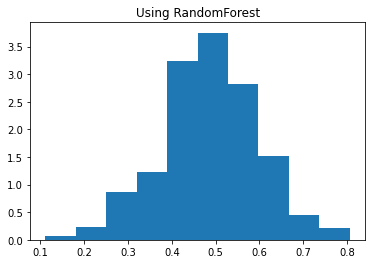

In [ ]:
#check the ovrlap conditions using randomForest
#get the propensity score function
g1 = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_with_allMediators, A=treatment, n_splits=10)
g1_ol = np.concatenate((g1[:364],g1[746:]))
hist(g1_ol, density=True)
plt.title("Using RandomForest")

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.1559216 , 0.21829025, 1.37211012, 2.52593   , 5.17659728,
        5.86265234, 3.8668558 , 1.09145123, 0.56131778, 0.09355296]),
 array([0.24127859, 0.28906905, 0.3368595 , 0.38464996, 0.43244042,
        0.48023088, 0.52802134, 0.57581179, 0.62360225, 0.67139271,
        0.71918317]),
 <a list of 10 Patch objects>)

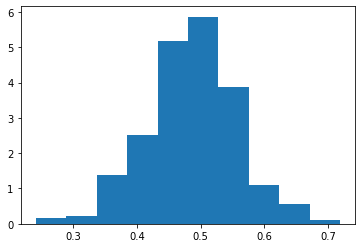

In [ ]:
#check the ovrlap conditions using Logistic Regression
g2 = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_with_allMediators, A=treatment, n_splits=10)
g2_ol = np.concatenate((g2[:364],g2[746:]))
hist(g2_ol, density=True)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.06962983, 0.22629695, 0.62666849, 1.18370714, 2.54148886,
        3.32482447, 2.43704411, 0.81815052, 0.38296407, 0.06962983]),
 array([0.0340003 , 0.11961377, 0.20522725, 0.29084072, 0.3764542 ,
        0.46206767, 0.54768115, 0.63329462, 0.7189081 , 0.80452157,
        0.89013505]),
 <a list of 10 Patch objects>)

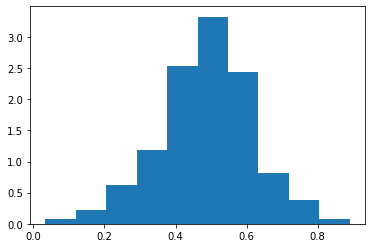

In [ ]:
#check the ovrlap conditions using XGBoost
g3 = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_with_allMediators, A=treatment, n_splits=10)
g3_ol = np.concatenate((g3[:364],g3[746:]))
hist(g3_ol, density=True)

## Calculate Natural Direct Effect with two mediators using RandomForest

### Calculate Q0 and Q1 model using Random Forest

In [ ]:
#calculate Q0 and Q1 model
Q0_RF,Q1_RF = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, X=confounders_with_allMediators, y=outcome, A=treatment, n_splits=10, output_type="continuous")
#Q0_RF

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_RF = exclude_moderate(pd.DataFrame({'g': g1, 'Q0': Q0_RF, 'Q1': Q1_RF, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_RF.head()

,g,Q0,Q1,A,Y
0,0.316989,72.299124,71.960764,0,77.000000
1,0.257728,68.104021,67.523853,0,73.666664
2,0.511793,72.793072,72.421547,0,70.000000
3,0.446282,73.574458,73.066637,0,81.000000
4,0.438106,74.199206,73.974197,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_RF, std_hat_RF = att_aiptw(**data_and_nuisance_estimates_RF)
print(f"The estimate using RandomForest is {tau_hat_RF} pm {1.96*std_hat_RF}")

The estimate using RandomForest is -2.424115601234582 pm 1.8265472554329019


## Calculate Natural Direct Effect with two mediators using Logistic Regression

### Calculate Q0 and Q1 model using Logistic Regression

In [ ]:
Q0_LR,Q1_LR = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, X=confounders_with_allMediators, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_LR = exclude_moderate(pd.DataFrame({'g': g2, 'Q0': Q0_LR, 'Q1': Q1_LR, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_LR.head()

,g,Q0,Q1,A,Y
0,0.367456,74.400815,72.369989,0,77.000000
1,0.367775,65.763319,64.326119,0,73.666664
2,0.489072,68.645615,67.065967,0,70.000000
3,0.261071,78.606101,77.026453,0,81.000000
4,0.450896,74.054152,72.637679,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_LR, std_hat_LR = att_aiptw(**data_and_nuisance_estimates_LR)
print(f"The estimate using RandomForest is {tau_hat_LR} pm {1.96*std_hat_LR}")

The estimate using RandomForest is -1.7545830996293097 pm 1.6116906687275725


## Calculate the Natural Direct Effect with two Mediators using XGBoost model

### Calculate Q0 and Q1 model using XGBoost

In [ ]:
Q0_XGB,Q1_XGB = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, X=confounders_with_allMediators, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_XGB = exclude_moderate(pd.DataFrame({'g': g3, 'Q0': Q0_XGB, 'Q1': Q1_XGB, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_XGB.head()

,g,Q0,Q1,A,Y
0,0.227087,77.488861,75.122292,0,77.000000
1,0.199275,66.383614,62.081127,0,73.666664
2,0.440174,72.696465,70.747185,0,70.000000
3,0.622674,70.690514,69.941917,0,81.000000
4,0.290809,75.049919,73.602463,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_XGB, std_hat_XGB = att_aiptw(**data_and_nuisance_estimates_XGB)
print(f"The estimate using RandomForest is {tau_hat_XGB} pm {1.96*std_hat_XGB}")

The estimate using RandomForest is -2.3732965265579797 pm 2.5775501827258482


# Natural Direct Effect with StudyHours as the mediator

## Check Overlap Conditions 0<Pr(A =1 |𝐗 = x, M1 = m1) < 1 using the three models

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.18854063, 0.45249751, 1.01811939, 2.0739469 , 3.01665003,
        3.12977441, 1.82884408, 0.6598922 , 0.20739469, 0.07541625]),
 array([0.10961905, 0.18866371, 0.26770837, 0.34675303, 0.42579769,
        0.50484234, 0.583887  , 0.66293166, 0.74197632, 0.82102098,
        0.90006564]),
 <a list of 10 Patch objects>)

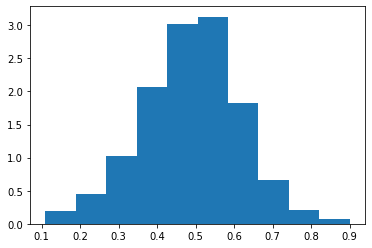

In [ ]:
#check the overlap conditions using randomForest
#get the propensity score function
g1_SH = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_with_mediatorStudyHours, A=treatment, n_splits=10)
g1_SH_ol = np.concatenate((g1_SH[:364],g1_SH[746:]))
hist(g1_SH_ol, density=True)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.16586695, 0.24880043, 0.62200108, 2.15627041, 4.02227366,
        5.51507625, 6.75907841, 6.09561059, 1.74160303, 0.49760086]),
 array([0.27255243, 0.30849239, 0.34443235, 0.38037231, 0.41631227,
        0.45225223, 0.48819219, 0.52413215, 0.56007211, 0.59601207,
        0.63195204]),
 <a list of 10 Patch objects>)

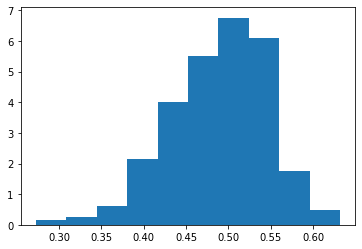

In [ ]:
#check the overlap conditions using Logistic Regression
g2_SH = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_with_mediatorStudyHours, A=treatment, n_splits=10)
g2_SH_ol = np.concatenate((g2_SH[:364],g2_SH[746:]))
hist(g2_SH_ol, density=True)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.03539834, 0.19469085, 0.46017837, 1.06195009, 2.58407855,
        3.84071948, 2.49558271, 0.7787634 , 0.31858503, 0.10619501]),
 array([0.03583595, 0.12003838, 0.20424081, 0.28844324, 0.37264567,
        0.4568481 , 0.54105053, 0.62525296, 0.70945539, 0.79365782,
        0.87786025]),
 <a list of 10 Patch objects>)

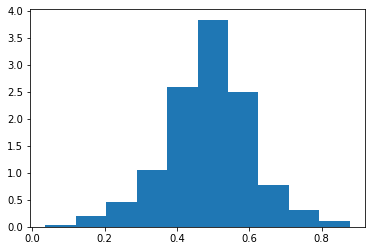

In [ ]:
#check the ovrlap conditions using XGBoost
g3_SH = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_with_mediatorStudyHours, A=treatment, n_splits=10)
g3_SH_ol = np.concatenate((g3_SH[:364],g3_SH[746:]))
hist(g3_SH_ol, density=True)

## Calculate Natural Direct Effect using RandomForest: Using StudyHours as the mediator

### Calculate Q0 and Q1 model using Random Forest

In [ ]:
# Calculate Q0 and Q1 model
Q0_RFSH,Q1_RFSH = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, X=confounders_with_mediatorStudyHours, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_RFSH = exclude_moderate(pd.DataFrame({'g': g1_SH, 'Q0': Q0_RFSH, 'Q1': Q1_RFSH, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_RFSH.head()

,g,Q0,Q1,A,Y
0,0.432461,72.627219,72.246202,0,77.000000
1,0.248581,67.910706,67.193627,0,73.666664
2,0.481052,72.367704,71.957374,0,70.000000
3,0.421837,73.347364,72.649354,0,81.000000
4,0.519283,74.291248,74.006197,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_RFSH, std_hat_RFSH = att_aiptw(**data_and_nuisance_estimates_RFSH)
print(f"The estimate is {tau_hat_RFSH} pm {1.96*std_hat_RFSH}")

The estimate is -2.425885038772201 pm 1.8370421997590096


## Calculate Natural Direct Effect using Logistic Regression: Using StudyHours as the mediator

### Calculate Q0 and Q1 model using Logistic Regression

In [ ]:
Q0_LRSH,Q1_LRSH = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, X=confounders_with_mediatorStudyHours, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_LRSH = exclude_moderate(pd.DataFrame({'g': g2_SH, 'Q0': Q0_LRSH, 'Q1': Q1_LRSH, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_LRSH.head()

,g,Q0,Q1,A,Y
0,0.407010,74.327267,72.283829,0,77.000000
1,0.380085,65.705040,64.250488,0,73.666664
2,0.539543,68.788454,67.227153,0,70.000000
3,0.310189,78.884170,77.322870,0,81.000000
4,0.522647,73.766872,72.331557,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_LRSH, std_hat_LRSH = att_aiptw(**data_and_nuisance_estimates_LRSH)
print(f"The estimate is {tau_hat_LRSH} pm {1.96*std_hat_LRSH}")

The estimate is -1.6982852478109984 pm 1.5987121171258265


## Calculate the Natural Direct Effect using XGBoost model: Using StudyHours as the Mediator

### Calculate Q0 and Q1 model using XGBoost

In [ ]:
Q0_XGSH,Q1_XGSH = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, X=confounders_with_mediatorStudyHours, y=outcome, A=treatment, n_splits=10, output_type="continuous")

### Combine the dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_XGSH = exclude_moderate(pd.DataFrame({'g': g3_SH, 'Q0': Q0_XGSH, 'Q1': Q1_XGSH, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_XGSH.head()

,g,Q0,Q1,A,Y
0,0.278625,77.259163,74.763947,0,77.000000
1,0.200761,66.603958,59.280952,0,73.666664
2,0.520494,72.521431,69.231903,0,70.000000
3,0.596783,66.622696,66.040443,0,81.000000
4,0.431568,75.098595,74.831985,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_XGSH, std_hat_XGSH = att_aiptw(**data_and_nuisance_estimates_XGSH)
print(f"The estimate is {tau_hat_XGSH} pm {1.96*std_hat_XGSH}")

The estimate is -2.571081234753055 pm 2.448954950217818


# Natural Direct Effect with Study Habits as the mediator

## Check Overlap Conditions 0<Pr(A =1 |𝐗 = x, M2 = m2) < 1 using the three models

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.03462105, 0.1384842 , 0.50200521, 1.28097882, 2.64851026,
        3.34093124, 2.44078396, 0.93476833, 0.20772629, 0.08655262]),
 array([0.0312381 , 0.11733098, 0.20342386, 0.28951674, 0.37560963,
        0.46170251, 0.54779539, 0.63388828, 0.71998116, 0.80607404,
        0.89216693]),
 <a list of 10 Patch objects>)

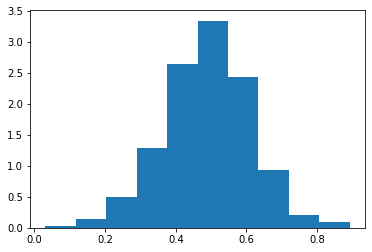

In [ ]:
#check the overlap conditions using randomForest
#get the propensity score function
g1_SB = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_with_mediatorStudyHabits, A=treatment, n_splits=10)
g1_SB_ol = np.concatenate((g1_SB[:364],g1_SB[746:]))                                      
hist(g1_SB_ol, density=True)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.03663219, 0.01831609, 0.16484485, 0.42127017, 2.69246587,
        4.90871329, 2.82067853, 0.89748862, 0.27474142, 0.05494828]),
 array([0.0312381 , 0.1126044 , 0.19397071, 0.27533702, 0.35670333,
        0.43806963, 0.51943594, 0.60080225, 0.68216855, 0.76353486,
        0.84490117]),
 <a list of 10 Patch objects>)

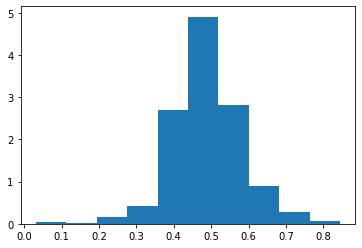

In [ ]:
g2_SB = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_with_mediatorStudyHabits, 
                                      A=treatment, n_splits=10)
g2_SB_ol = np.concatenate((g2_SB[:364],g1_SB[746:]))
hist(g2_SB_ol, density=True)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.03608161, 0.21648964, 0.52318329, 0.95616257, 2.50767165,
        3.49991582, 2.74220209, 1.15461141, 0.34277526, 0.12628562]),
 array([0.0312381 , 0.113846  , 0.19645391, 0.27906181, 0.36166972,
        0.44427762, 0.52688553, 0.60949343, 0.69210134, 0.77470924,
        0.85731715]),
 <a list of 10 Patch objects>)

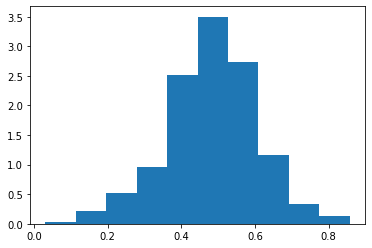

In [ ]:
g3_SB = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_with_mediatorStudyHabits, 
                                      A=treatment, n_splits=10)
g3_SB_ol = np.concatenate((g3_SB[:364],g1_SB[746:]))
hist(g3_SB_ol, density=True)

## Calculate Natural Direct Effect using RandomForest: Using Study Habits as the mediator

### Calculate Q0 and Q1 model using RandomForest

In [ ]:
Q0_RFSB,Q1_RFSB = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, 
                                             X=confounders_with_mediatorStudyHabits, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_RFSB = exclude_moderate(pd.DataFrame({'g': g1_SB, 'Q0': Q0_RFSB, 'Q1': Q1_RFSB, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_RFSB.head()

,g,Q0,Q1,A,Y
0,0.284036,71.131685,70.508828,0,77.000000
1,0.265508,67.594057,65.971519,0,73.666664
2,0.691086,68.636775,68.209594,0,70.000000
3,0.661073,69.222686,68.892401,0,81.000000
4,0.456331,71.657158,71.619395,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_RFSB, std_hat_RFSB = att_aiptw(**data_and_nuisance_estimates_RFSB)
print(f"The estimate using RandomForest is {tau_hat_RFSB} pm {1.96*std_hat_RFSB}")

The estimate using RandomForest is -3.6929107892747526 pm 2.760470528992866


## Calculate Natural Direct Effect using LogisticRegression: Using Study Habits as the mediator

### Calculate Q0 and Q1 model using Logistic Regression

In [ ]:
Q0_LRSB,Q1_LRSB = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, 
                                             X=confounders_with_mediatorStudyHabits, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_LRSB = exclude_moderate(pd.DataFrame({'g': g2_SB, 'Q0': Q0_LRSB, 'Q1': Q1_LRSB, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_LRSB.head()

,g,Q0,Q1,A,Y
0,0.398288,72.574095,70.301962,0,77.000000
1,0.387782,64.772486,63.101131,0,73.666664
2,0.538986,66.451156,64.611026,0,70.000000
3,0.406636,69.112386,67.272256,0,81.000000
4,0.487341,72.313546,70.693444,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_LRSB, std_hat_LRSB = att_aiptw(**data_and_nuisance_estimates_LRSB)
print(f"The estimate using LogisticRegression is {tau_hat_LRSB} pm {1.96*std_hat_LRSB}")

The estimate using LogisticRegression is -2.0579612230360245 pm 1.631844226495338


## Calculate Natural Direct Effect using XGBoost: Using Study Habits as the mediator

### Calculate Q0 and Q1 model using XGBoost

In [ ]:
Q0_XGSB,Q1_XGSB = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, 
                                             X=confounders_with_mediatorStudyHabits, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

### Combine the Dataset for g, Q0, Q1, A, and Y values

In [ ]:
data_and_nuisance_estimates_XGSB = exclude_moderate(pd.DataFrame({'g': g3_SB, 'Q0': Q0_XGSB, 'Q1': Q1_XGSB, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_XGSB.head()

,g,Q0,Q1,A,Y
0,0.294540,74.226723,71.850433,0,77.000000
1,0.258790,64.716011,59.577900,0,73.666664
2,0.712588,68.861565,65.525139,0,70.000000
3,0.440861,70.527634,69.541443,0,81.000000
4,0.408167,70.058609,69.259811,0,81.500000


### Calculate the Natural Direct Effect using the ATU formula

In [ ]:
tau_hat_XGSB, std_hat_XGSB = att_aiptw(**data_and_nuisance_estimates_XGSB)
print(f"The estimate using XGBoost is {tau_hat_XGSB} pm {1.96*std_hat_XGSB}")

The estimate using XGBoost is -2.8114767903316187 pm 2.388752939243781


# Estimate the Total Effect using ATE

### Check Overlap Conditions 0<Pr(A =1 |𝐗 = x, M1 = m1, M2 = m2) < 1 using the three models

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.07479898, 0.10471857, 0.25431652, 1.85501465, 3.62027052,
        2.84236115, 0.88262794, 0.29919591, 0.04487939, 0.05983918]),
 array([0.00378788, 0.10340909, 0.2030303 , 0.30265152, 0.40227273,
        0.50189394, 0.60151515, 0.70113636, 0.80075758, 0.90037879,
        1.        ]),
 <a list of 10 Patch objects>)

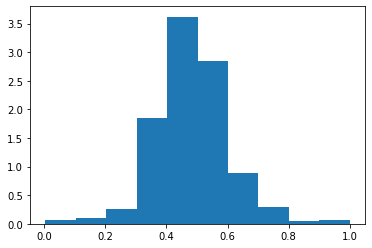

In [ ]:

#get the propensity score function
g1_TE = treatment_k_fold_fit_and_predict(make_gmodel_randomForest, X=confounders_without_Mediator, 
                                      A=treatment, n_splits=10)
g1_TE_ol = np.concatenate((g1_TE[:364],g1_SB[746:]))
hist(g1_TE_ol, density=True)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.03663219, 0.01831609, 0.16484485, 0.3296897 , 2.36277617,
        5.87946629, 2.47267274, 0.69601159, 0.27474142, 0.05494828]),
 array([0.0312381 , 0.1126044 , 0.19397071, 0.27533702, 0.35670333,
        0.43806963, 0.51943594, 0.60080225, 0.68216855, 0.76353486,
        0.84490117]),
 <a list of 10 Patch objects>)

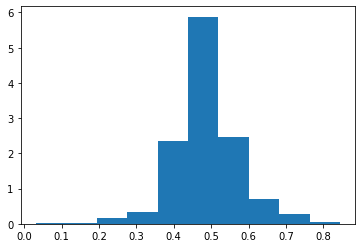

In [ ]:
g2_TE = treatment_k_fold_fit_and_predict(make_gmodel_logisticRegression, X=confounders_without_Mediator, 
                                      A=treatment, n_splits=10)
g2_TE_ol = np.concatenate((g2_TE[:364],g1_SB[746:]))
hist(g2_TE_ol, density=True)

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)


(array([0.07479898, 0.10471857, 0.25431652, 1.85501465, 3.62027052,
        2.84236115, 0.88262794, 0.29919591, 0.04487939, 0.05983918]),
 array([0.00378788, 0.10340909, 0.2030303 , 0.30265152, 0.40227273,
        0.50189394, 0.60151515, 0.70113636, 0.80075758, 0.90037879,
        1.        ]),
 <a list of 10 Patch objects>)

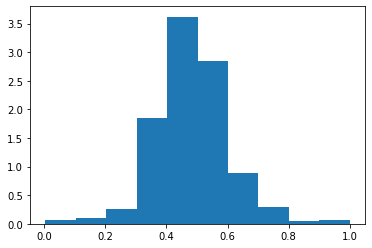

In [ ]:
g3_TE = treatment_k_fold_fit_and_predict(make_gmodel_XGBClassifier, X=confounders_without_Mediator, 
                                      A=treatment, n_splits=10)
g3_TE_ol = np.concatenate((g1_TE[:364],g1_SB[746:]))
hist(g3_TE_ol, density=True)

### Calculate Total Effect using RandomForest

In [ ]:
Q0_RFTE,Q1_RFTE = outcome_k_fold_fit_and_predict(make_Qmodel_randomForest, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_RFTE = exclude_moderate(pd.DataFrame({'g': g1_TE, 'Q0': Q0_RFTE, 'Q1': Q1_RFTE, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_RFTE.head()

,g,Q0,Q1,A,Y
0,0.376708,71.186335,66.803693,0,77.000000
1,0.324319,69.780694,66.104271,0,73.666664
2,0.640339,70.325724,68.095118,0,70.000000
3,0.364450,69.518177,67.319265,0,81.000000
4,0.579043,72.097452,70.847277,0,81.500000


In [ ]:
tau_hat_RFTE, std_hat_RFTE = att_aiptw(**data_and_nuisance_estimates_RFTE)
print(f"The estimate using RandomForest is {tau_hat_RFTE} pm {1.96*std_hat_RFTE}")

The estimate using RandomForest is inf pm nan


### Calculate Total Effect using Logistic Regression

In [ ]:
Q0_LRTE,Q1_LRTE = outcome_k_fold_fit_and_predict(make_Qmodel_linearRegression, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_LRTE = exclude_moderate(pd.DataFrame({'g': g2_TE, 'Q0': Q0_LRTE, 'Q1': Q1_LRTE, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_LRTE.head()

,g,Q0,Q1,A,Y
0,0.456252,69.044088,66.615084,0,77.000000
1,0.403838,67.693013,65.866381,0,73.666664
2,0.528368,70.077743,68.152090,0,70.000000
3,0.421758,68.350808,66.425155,0,81.000000
4,0.513315,71.925262,70.085348,0,81.500000


In [ ]:
tau_hat_LRTE, std_hat_LRTE = att_aiptw(**data_and_nuisance_estimates_LRTE)
print(f"The estimate using Logistic Regression is {tau_hat_LRTE} pm {1.96*std_hat_LRTE}")

The estimate using Logistic Regression is -2.2091922486069926 pm 1.6352836765340613


### Calculate Total Effect using XGBoost

In [ ]:
Q0_XGTE,Q1_XGTE = outcome_k_fold_fit_and_predict(make_Qmodel_XGBoost, 
                                             X=confounders_without_Mediator, y=outcome, 
                                             A=treatment, n_splits=10, output_type="continuous")

In [ ]:
data_and_nuisance_estimates_XGTE = exclude_moderate(pd.DataFrame({'g': g3_TE, 'Q0': Q0_XGTE, 'Q1': Q1_XGTE, 'A': treatment, 'Y': outcome}))
data_and_nuisance_estimates_XGTE.head()

,g,Q0,Q1,A,Y
0,0.388895,72.064819,66.912010,0,77.000000
1,0.325704,70.125023,65.910683,0,73.666664
2,0.553644,71.329063,68.893646,0,70.000000
3,0.368042,71.262108,66.487671,0,81.000000
4,0.557024,72.482079,70.086472,0,81.500000


In [ ]:
tau_hat_XGTE, std_hat_XGTE = att_aiptw(**data_and_nuisance_estimates_XGTE)
print(f"The estimate using XGBoost is {tau_hat_XGTE} pm {1.96*std_hat_XGTE}")

The estimate using XGBoost is -1.862313596001122 pm 1.825616471795112


# The table of results

## Natural Direct Effect

In [ ]:
NDE_table = [['Outcome','Type of causal effect','Mediator excluded', 'Model', 'Estimate','p/m', 'Standard Error'], 
         ['Fall_grade','Natural Direct Effect', 'Study Hours', 'RandomForest',tau_hat_RFSH,1.96*std_hat_RFSH, std_hat_RFSH], 
         ['Fall_grade','Natural Direct Effect', 'Study Hours', 'Logistic Regression',tau_hat_LRSH,1.96*std_hat_LRSH,std_hat_LRSH],
         ['Fall_grade','Natural Direct Effect', 'Study Hours', 'XGBoost',tau_hat_XGSH,1.96*std_hat_XGSH,std_hat_XGSH],
         ['Fall_grade','Natural Direct Effect', 'Study Habits', 'RandomForest',tau_hat_RFSB,1.96*std_hat_RFSB,std_hat_RFSB], 
         ['Fall_grade','Natural Direct Effect', 'Study Habits', 'Logistic Regression',tau_hat_LRSB,1.96*std_hat_LRSB,std_hat_LRSB],
         ['Fall_grade','Natural Direct Effect', 'Study Habits', 'XGBoost',tau_hat_XGSB,1.96*std_hat_XGSB,std_hat_XGSB],
         ['Fall_grade','Natural Direct Effect', 'Study Hours and Study Habits', 'RandomForest',tau_hat_RF,1.96*std_hat_RF,std_hat_RF], 
         ['Fall_grade','Natural Direct Effect', 'Study Hours and Study Habits', 'Logistic Regression',tau_hat_LR,1.96*std_hat_LR,std_hat_LR],
         ['Fall_grade','Natural Direct Effect', 'Study Hours and Study Habits', 'XGBoost',tau_hat_XGB,1.96*std_hat_XGB,std_hat_XGB]]

In [ ]:
TE_table = [['Outcome','Type of causal effect', 'Model', 'Estimate','p/m', 'Standard Error'],
            ['Fall_grade','Total Effect', 'RandomForest',tau_hat_RFTE,1.96*std_hat_RFTE, std_hat_RFTE], 
            ['Fall_grade','Total Effect', 'Logistic Regression',tau_hat_LRTE,1.96*std_hat_LRTE, std_hat_LRTE],
            ['Fall_grade','Total Effect', 'XGBoost',tau_hat_XGTE,1.96*std_hat_XGTE, std_hat_XGTE]]

In [ ]:
df_NDE = pd.DataFrame(NDE_table)
df_NDE.columns = df_NDE.iloc[0]
df_NDE = df_NDE[1:]
df_NDE

,Outcome,Type of causal effect,Mediator excluded,Model,Estimate,p/m,Standard Error
1,Fall_grade,Natural Direct Effect,Study Hours,RandomForest,-2.425885,1.837042,0.937266
2,Fall_grade,Natural Direct Effect,Study Hours,Logistic Regression,-1.698285,1.598712,0.815669
3,Fall_grade,Natural Direct Effect,Study Hours,XGBoost,-2.571081,2.448955,1.249467
4,Fall_grade,Natural Direct Effect,Study Habits,RandomForest,-3.692911,2.760471,1.408403
5,Fall_grade,Natural Direct Effect,Study Habits,Logistic Regression,-2.057961,1.631844,0.832574
6,Fall_grade,Natural Direct Effect,Study Habits,XGBoost,-2.811477,2.388753,1.218751
7,Fall_grade,Natural Direct Effect,Study Hours and Study Habits,RandomForest,-2.424116,1.826547,0.931912
8,Fall_grade,Natural Direct Effect,Study Hours and Study Habits,Logistic Regression,-1.754583,1.611691,0.822291
9,Fall_grade,Natural Direct Effect,Study Hours and Study Habits,XGBoost,-2.373297,2.57755,1.315077


In [ ]:
df_TE = pd.DataFrame(TE_table)
df_TE.columns = df_TE.iloc[0]
df_TE = df_TE[1:]
df_TE

,Outcome,Type of causal effect,Model,Estimate,p/m,Standard Error
1,Fall_grade,Total Effect,RandomForest,inf,NaN,NaN
2,Fall_grade,Total Effect,Logistic Regression,-2.209192,1.635284,0.834328
3,Fall_grade,Total Effect,XGBoost,-1.862314,1.825616,0.931437


## Table of Natural Indirect Effect

In [ ]:
NIE_table = [['Outcome','Type of causal effect','Through which Mediator', 'Model', 'Estimate'], 
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Hours', 'RandomForest',tau_hat_RFTE - tau_hat_RFSH], 
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Hours', 'Logistic Regression',tau_hat_LRTE - tau_hat_LRSH],
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Hours', 'XGBoost',tau_hat_XGTE - tau_hat_XGSH],
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Habits', 'RandomForest',tau_hat_RFTE - tau_hat_RFSB], 
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Habits', 'Logistic Regression',tau_hat_LRTE - tau_hat_LRSB],
         ['Fall_grade','Natural Indirect Direct Effect', 'Study Habits', 'XGBoost',tau_hat_XGTE - tau_hat_XGSB]]

In [ ]:
df_NIE = pd.DataFrame(NIE_table)
df_NIE.columns = df_NIE.iloc[0]
df_NIE = df_NIE[1:]
df_NIE

,Outcome,Type of causal effect,Through which Mediator,Model,Estimate
1,Fall_grade,Natural Indirect Direct Effect,Study Hours,RandomForest,inf
2,Fall_grade,Natural Indirect Direct Effect,Study Hours,Logistic Regression,-0.510907
3,Fall_grade,Natural Indirect Direct Effect,Study Hours,XGBoost,0.708768
4,Fall_grade,Natural Indirect Direct Effect,Study Habits,RandomForest,inf
5,Fall_grade,Natural Indirect Direct Effect,Study Habits,Logistic Regression,-0.151231
6,Fall_grade,Natural Indirect Direct Effect,Study Habits,XGBoost,0.949163


## Table of Sanity checks results 

In [ ]:
San_table = [['Outcome','Mediators','Model','Q model MSE','Q model baseline','g model CE','g model baseline'],
             ['Fall_grade', 'none', 'RandomForest', test_mse_RF0, baseline_mse_0, test_ce_RF0, baseline_ce_0],
             ['Fall_grade', 'none', 'LogisticRegression', test_mse_LR0, baseline_mse_0, test_ce_LR0, baseline_ce_0],
             ['Fall_grade', 'none', 'XGBoost', test_mse_XGB0, baseline_mse_0, test_ce_XGB0, baseline_ce_0],
             ['Fall_grade', 'both', 'RandomForest', test_mse_RF1, baseline_mse_1, test_ce_RF1, baseline_ce_1],
             ['Fall_grade', 'both', 'LogisticRegression', test_mse_LR1, baseline_mse_1, test_ce_LR1, baseline_ce_1],
             ['Fall_grade', 'both', 'RandomForest', test_mse_XGB1, baseline_mse_1, test_ce_XGB1, baseline_ce_1],
             ['Fall_grade', 'StudyHours', 'RandomForest', test_mse_RF2, baseline_mse_2, test_ce_RF2, baseline_ce_2],
             ['Fall_grade', 'StudyHours', 'LogisticRegression', test_mse_LR2, baseline_mse_2, test_ce_LR2, baseline_ce_2],
             ['Fall_grade', 'StudyHours', 'XGBoost', test_mse_XGB2, baseline_mse_2, test_ce_XGB2, baseline_ce_2],
             ['Fall_grade', 'StudyHabits', 'RandomForest', test_mse_RF3, baseline_mse_3, test_ce_RF3, baseline_ce_3],
             ['Fall_grade', 'StudyHabits', 'LogisticRegression', test_mse_LR3, baseline_mse_3, test_ce_LR3, baseline_ce_3],
             ['Fall_grade', 'StudyHabits', 'XGBoost', test_mse_XGB3, baseline_mse_3, test_ce_XGB3, baseline_ce_3],
             
             ]

In [ ]:
df_san = pd.DataFrame(San_table)
df_san.columns = df_san.iloc[0]
df_san = df_san[1:]
df_san

,Outcome,Mediators,Model,Q model MSE,Q model baseline,g model CE,g model baseline
1,Fall_grade,none,RandomForest,152.611823,151.601951,0.746794,0.692866
2,Fall_grade,none,LogisticRegression,149.51816,151.601951,0.690182,0.692866
3,Fall_grade,none,XGBoost,157.875933,151.601951,0.714846,0.692866
4,Fall_grade,both,RandomForest,169.400559,182.096039,0.722922,0.694627
5,Fall_grade,both,LogisticRegression,168.510748,182.096039,0.68824,0.694627
6,Fall_grade,both,RandomForest,181.723137,182.096039,0.761442,0.694627
7,Fall_grade,StudyHours,RandomForest,121.740535,130.438943,0.727428,0.695686
8,Fall_grade,StudyHours,LogisticRegression,121.582864,130.438943,0.709168,0.695686
9,Fall_grade,StudyHours,XGBoost,127.014899,130.438943,0.6978,0.695686
10,Fall_grade,StudyHabits,RandomForest,146.637146,149.82793,0.730618,0.692666
